# 1. Introdução

Este notebook tem como objetivo explorar e analisar bases de dados fornecidas para o Desafio Datathon da FIAP. O foco principal é compreender os dados disponíveis, realizar uma análise exploratória e propor um modelo de predição adequado ao desafio. Ao longo do notebook, serão documentados os principais insights, etapas de pré-processamento, seleção de variáveis e justificativas para as escolhas metodológicas, visando alcançar os melhores resultados preditivos possíveis.

## 1.2 Importações

In [1]:
#importações
import pandas as pd
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib # Importar joblib para salvar e carregar modelos



# 2. Exploração das bases de dados

## 2.1 base applicantes.json
Applicants.json -> É chaveado pelo código do candidato e possui todas as informações referentes ao candidato: Informações básicas, pessoais, profissionais, formação e o cv. Informações importantes desse json:

Nível acadêmico, de inglês e espanhol
Conhecimentos técnicos
Área de atuação
Cv completo
 

Utilização: Por exemplo, a vaga 10976 (chave no Jobs.json), possui 25 prospecções (chave 10976 no prospects.json), onde o candidato “Sr. Thales Freitas”  (chave 41496 no applicants.json) foi contratado.

 

## 2.2 base vagas.json

vagas.json -> É chaveado pelo código da vaga e possui as informações referentes a vaga aberta no nosso ats divididas em Informações básicas, perfil da vaga e benefícios. Aqui temos dados importantes como, por exemplo:

indicação se é vaga SAP ou não
Cliente solicitante
Nível profissional e nível de idiomas requeridos
Principais atividades e competências técnicas requeridas




## 2.3 base prospects.json

Prospects.json -> Também é chaveado pelo código da vaga e possui todas as prospecções da vaga.

Lista de prospecções com o código, nome, comentário e situação do candidato na vaga em questão


In [2]:
# --- Caminhos dos arquivos  ---
raw_data_pasta = '../data/raw/'
applicants_file = raw_data_pasta + 'applicants.json' 
vagas_file = raw_data_pasta + 'vagas.json'
prospects_file = raw_data_pasta + 'prospects.json'

# Carregar os arquivos JSON
# Tenta carregar os arquivos JSON fornecidos pelo usuário.
# Em caso de erro (arquivo não encontrado ou JSON inválido), exibe uma mensagem e encerra.
try:
    with open(applicants_file, 'r', encoding='utf-8') as f:
        applicants_data = json.load(f)
    with open(prospects_file, 'r', encoding='utf-8') as f:
        prospects_data = json.load(f)
    with open(vagas_file, 'r', encoding='utf-8') as f:
        vagas_data = json.load(f)

    print("Arquivos JSON carregados com sucesso.")

except FileNotFoundError as e:
    print(f"Erro ao carregar o arquivo: {e}. Certifique-se de que os arquivos estão no diretório correto.")
    exit()
except json.JSONDecodeError as e:
    print(f"Erro ao decodificar JSON: {e}. Verifique a integridade dos arquivos JSON.")
    exit()

# Normalizar e criar DataFrames
# Processa o dicionário de candidatos para criar um DataFrame plano.
# Combina informações básicas e pessoais, e concatena o histórico profissional em uma única string.
applicants_list = []
for code, data in applicants_data.items():
    applicant_info = {'codigo_profissional': code}
    # Combina informações de 'infos_basicas' e 'informacoes_pessoais'
    if 'infos_basicas' in data:
        applicant_info.update(data['infos_basicas'])
    if 'informacoes_pessoais' in data:
        applicant_info.update(data['informacoes_pessoais'])

    # Adiciona o CV completo se existir, caso contrário, string vazia.
    if 'cv' in data:
        applicant_info['cv_completo'] = data['cv']
    else:
        applicant_info['cv_completo'] = ''

    # Concatena as descrições de atividades do histórico profissional em uma única string.
    if 'historico_profissional' in data and isinstance(data['historico_profissional'], list):
        applicant_info['historico_profissional_texto'] = " ".join([exp.get('descricao_atividades', '') for exp in data['historico_profissional']])
    else:
        applicant_info['historico_profissional_texto'] = ''

    applicants_list.append(applicant_info)

df_applicants = pd.DataFrame(applicants_list)

# Processa o dicionário de prospects para criar um DataFrame onde cada linha é uma aplicação.
# Expande a lista de 'prospects' para ter uma linha por aplicação.
prospects_list = []
for job_code, job_data in prospects_data.items():
    if 'prospects' in job_data:
        for prospect in job_data['prospects']:
            prospect_info = {
                'codigo_vaga': job_code,
                'titulo_vaga_prospect': job_data.get('titulo', ''),
                'modalidade_vaga_prospect': job_data.get('modalidade', '')
            }
            prospect_info.update(prospect)
            prospects_list.append(prospect_info)

df_prospects = pd.DataFrame(prospects_list)

# Processa o dicionário de vagas para criar um DataFrame plano.
# Combina informações básicas e de perfil da vaga.
vagas_list = []
for code, data in vagas_data.items():
    vaga_info = {'codigo_vaga': code}
    if 'informacoes_basicas' in data:
        vaga_info.update(data['informacoes_basicas'])
    if 'perfil_vaga' in data:
        vaga_info.update(data['perfil_vaga'])
    vagas_list.append(vaga_info)

df_vagas = pd.DataFrame(vagas_list)

print("\nDataFrames iniciais criados.")



print("\n--- DataFrame de Candidatos (df_applicants) ---")
print(df_applicants.head())
print("\nInformações do DataFrame de Candidatos:")
print(df_applicants.info())
print("\nValores nulos no DataFrame de Candidatos:")
print(df_applicants.isnull().sum()[df_applicants.isnull().sum() > 0])


print("\n--- DataFrame de Aplicações (df_prospects) ---")
print(df_prospects.head())
print("\nInformações do DataFrame de Aplicações:")
print(df_prospects.info())
print("\nValores nulos no DataFrame de Aplicações:")
print(df_prospects.isnull().sum()[df_prospects.isnull().sum() > 0])


print("\n--- DataFrame de Vagas (df_vagas) ---")
print(df_vagas.head())
print("\nInformações do DataFrame de Vagas:")
print(df_vagas.info())
print("\nValores nulos no DataFrame de Vagas:")
print(df_vagas.isnull().sum()[df_vagas.isnull().sum() > 0])

Arquivos JSON carregados com sucesso.

DataFrames iniciais criados.

--- DataFrame de Candidatos (df_applicants) ---
  codigo_profissional telefone_recado         telefone  \
0               31000                  (11) 97048-2708   
1               31001                  (11) 93723-4396   
2               31002                  (11) 92399-9824   
3               31003                  (11) 98100-1727   
4               31004                  (11) 92517-2678   

         objetivo_profissional         data_criacao       inserido_por  \
0                               10-11-2021 07:29:49       Luna Correia   
1      Analista Administrativo  10-11-2021 08:56:16      Laura Pacheco   
2  Administrativo | Financeiro  10-11-2021 09:01:00      Laura Pacheco   
3          Área administrativa  10-11-2021 09:08:13      Laura Pacheco   
4                               10-11-2021 09:18:46  Maria Clara Pires   

                               email                 local sabendo_de_nos_por  \
0       

# 3. Merge e Salvamento do dataframe Resultante em CSV


In [3]:
# --- Caminhos do arquivo resultante  ---
processed_data_pasta = '../data/processed/'
merged_data_processed = processed_data_pasta + 'merged_data_processed.csv' 


# --- Merging DataFrames ---
# Renomeia a coluna 'codigo' em df_prospects para 'codigo_profissional' para corresponder a df_applicants.
df_prospects = df_prospects.rename(columns={'codigo': 'codigo_profissional'})

# Mescla df_prospects com df_applicants usando 'codigo_profissional' como chave.
# 'how='left'' garante que todas as linhas de df_prospects sejam mantidas.
merged_df = pd.merge(df_prospects, df_applicants, on='codigo_profissional', how='left', suffixes=('_prospect', '_applicant'))

# Converte a coluna 'codigo_vaga' para string em ambos os DataFrames antes da mesclagem para evitar problemas de tipo.
merged_df['codigo_vaga'] = merged_df['codigo_vaga'].astype(str)
df_vagas['codigo_vaga'] = df_vagas['codigo_vaga'].astype(str)

# Mescla o DataFrame resultante com df_vagas usando 'codigo_vaga' como chave.
merged_df = pd.merge(merged_df, df_vagas, on='codigo_vaga', how='left', suffixes=('_prospect_job', '_job_details'))

print("Merge dos DataFrames concluído.")

# --- Define the Target Variable ---
# Define a variável alvo 'contratado'.
# Um candidato é considerado 'contratado' se a 'situacao_candidado' for "Contratado pela Decision" ou "Contratado como Hunting".
hired_statuses = ["Contratado pela Decision", "Contratado como Hunting"]
merged_df['contratado'] = merged_df['situacao_candidado'].isin(hired_statuses).astype(int)

print("\nVariável alvo 'contratado' criada e corrigida.")

# --- Handling Missing Values for Text Columns ---
# Preenche valores NaN em colunas de texto relevantes com strings vazias para evitar erros no TF-IDF.
text_cols_applicants = ['objetivo_profissional', 'cv_completo', 'historico_profissional_texto']
text_cols_vagas = ['titulo_vaga', 'principais_atividades', 'competencia_tecnicas_e_comportamentais', 'demais_observacoes', 'areas_atuacao']

for col in text_cols_applicants:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna('')
    else:
        print(f"Aviso: Coluna '{col}' não encontrada no DataFrame mesclado.")

for col in text_cols_vagas:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna('')
    else:
        print(f"Aviso: Coluna '{col}' não encontrada no DataFrame mesclado.")

print("\nValores NaN em colunas de texto preenchidos com string vazia.")

# --- Feature Engineering: Combine Text Fields for Applicants and Vagas ---
# Cria uma feature de texto combinada para os candidatos.
merged_df['applicant_text_features'] = merged_df['objetivo_profissional'] + ' ' + \
                                       merged_df['historico_profissional_texto'] + ' ' + \
                                       merged_df['cv_completo']

# Cria uma feature de texto combinada para as vagas.
merged_df['job_text_features'] = merged_df['titulo_vaga_prospect'] + ' ' + \
                                  merged_df['titulo_vaga'] + ' ' + \
                                  merged_df['principais_atividades'] + ' ' + \
                                  merged_df['competencia_tecnicas_e_comportamentais'] + ' ' + \
                                  merged_df['demais_observacoes'] + ' ' + \
                                  merged_df['areas_atuacao']

print("\nCampos de texto combinados para candidatos e vagas.")

# --- Drop Unnecessary Columns ---
# Lista de colunas a serem excluídas, conforme solicitado pelo usuário.
columns_to_drop = [
    'codigo_vaga',
    'codigo_profissional',
    'data_candidatura',
    'ultima_atualizacao',
    'recrutador',
    'telefone_recado',
    'telefone_prospect_job',
    'data_criacao',
    'inserido_por',
    'email',
    'sabendo_de_nos_por',
    'data_atualizacao',
    'nome_applicant',
    'data_aceite',
    'cpf',
    'fonte_indicacao',
    'email_secundario',
    'data_nascimento',
    'telefone_celular',
    'sexo',
    'estado_civil',
    'endereco',
    'skype',
    'url_linkedin',
    'facebook',
    'download_cv',
    'data_requicisao',
    'cliente',
    'solicitante_cliente',
    'empresa_divisao',
    'requisitante',
    'analista_responsavel',
    'tipo_contratacao', # Esta coluna será mantida como categórica, mas removida da lista de drop se já estiver lá.
    'prazo_contratacao',
    'prioridade_vaga',
    'origem_vaga', # Esta coluna será mantida como categórica, mas removida da lista de drop se já estiver lá.
    'superior_imediato',
    'nome',
    'telefone_job_details',
    'pais', # Esta coluna será mantida como categórica, mas removida da lista de drop se já estiver lá.
    'estado', # Esta coluna será mantida como categórica, mas removida da lista de drop se já estiver lá.
    'cidade', # Esta coluna será mantida como categórica, mas removida da lista de drop se já estiver lá.
    'bairro',
    'regiao', # Esta coluna será mantida como categórica, mas removida da lista de drop se já estiver lá.
    'local_trabalho',
    'horario_trabalho', # Esta coluna será mantida como categórica, mas removida da lista de drop se já estiver lá.
    'viagens_requeridas',
    'equipamentos_necessarios',
    'data_inicial',
    'data_final',
    'nome_substituto'
]

# Remove as colunas especificadas, se existirem no DataFrame.
# Cria uma cópia da lista para evitar modificar a lista durante a iteração.
columns_to_drop_safe = list(columns_to_drop)

# Remove da lista de drop as colunas que são usadas como features categóricas ou textuais combinadas.
# Isso garante que não removamos features importantes que já estamos utilizando.
# As colunas 'pcd', 'vaga_especifica_para_pcd', 'nivel profissional', 'nivel_academico',
# 'nivel_ingles', 'nivel_espanhol', 'modalidade_vaga_prospect', 'faixa_etaria'
# já estão sendo usadas como features categóricas e não devem ser removidas.
# As colunas usadas para 'applicant_text_features' e 'job_text_features' também não devem ser removidas.

# Colunas que são usadas como features categóricas e NÃO devem ser removidas:
categorical_cols_to_keep = [
    'modalidade_vaga_prospect',
    'tipo_contratacao',
    'nivel profissional',
    'nivel_academico',
    'nivel_ingles',
    'nivel_espanhol',
    'sexo',
    'estado_civil',
    'pcd',
    'pais',
    'estado',
    'cidade',
    'regiao',
    'faixa_etaria',
    'horario_trabalho',
    'vaga_especifica_para_pcd',
    'origem_vaga'
]

# Colunas que são usadas para criar features de texto combinadas e NÃO devem ser removidas:
text_cols_to_keep = [
    'objetivo_profissional', 'cv_completo', 'historico_profissional_texto',
    'titulo_vaga_prospect', 'titulo_vaga', 'principais_atividades',
    'competencia_tecnicas_e_comportamentais', 'demais_observacoes', 'areas_atuacao'
]

# Filtra a lista de colunas a serem removidas, excluindo as que devem ser mantidas.
final_columns_to_drop = [col for col in columns_to_drop_safe if col not in categorical_cols_to_keep and col not in text_cols_to_keep]


for col in final_columns_to_drop:
    if col in merged_df.columns:
        merged_df = merged_df.drop(columns=[col])
        print(f"Coluna '{col}' removida.")
    else:
        print(f"Aviso: Coluna '{col}' não encontrada e não pode ser removida.")


# Salva o DataFrame processado para uso posterior no treinamento do modelo.
merged_df.to_csv(merged_data_processed, index=False)
print(f'\nDataFrame processado salvo como {merged_data_processed}.')

# Exibe as primeiras linhas e informações do DataFrame mesclado para verificação.
print("\n--- DataFrame Mesclado (merged_df) - Primeiras 5 linhas ---")
print(merged_df.head())

print("\n--- Informações do DataFrame Mesclado ---")
print(merged_df.info())

print("\n--- Contagem de valores na coluna 'contratado' ---")
print(merged_df['contratado'].value_counts())


Merge dos DataFrames concluído.

Variável alvo 'contratado' criada e corrigida.

Valores NaN em colunas de texto preenchidos com string vazia.

Campos de texto combinados para candidatos e vagas.
Coluna 'codigo_vaga' removida.
Coluna 'codigo_profissional' removida.
Coluna 'data_candidatura' removida.
Coluna 'ultima_atualizacao' removida.
Coluna 'recrutador' removida.
Coluna 'telefone_recado' removida.
Coluna 'telefone_prospect_job' removida.
Coluna 'data_criacao' removida.
Coluna 'inserido_por' removida.
Coluna 'email' removida.
Coluna 'sabendo_de_nos_por' removida.
Coluna 'data_atualizacao' removida.
Coluna 'nome_applicant' removida.
Coluna 'data_aceite' removida.
Coluna 'cpf' removida.
Coluna 'fonte_indicacao' removida.
Coluna 'email_secundario' removida.
Coluna 'data_nascimento' removida.
Coluna 'telefone_celular' removida.
Coluna 'endereco' removida.
Coluna 'skype' removida.
Coluna 'url_linkedin' removida.
Coluna 'facebook' removida.
Coluna 'download_cv' removida.
Coluna 'data_requ

# 4. Treinamento do modelo 

DataFrame processado ../data/processed/merged_data_processed.csv carregado com sucesso.

Iniciando vetorização TF-IDF para features de texto com stop words em português...
Shape do TF-IDF para candidatos: (53759, 2194)
Shape do TF-IDF para vagas: (53759, 5000)

Iniciando One-Hot Encoding para features categóricas...
Shape das features categóricas codificadas: (53759, 348)

Shape final da matriz de features (X): (53759, 7542)
Shape final do vetor de rótulos (y): (53759,)

Shape de X_train: (43007, 7542)
Shape de X_test: (10752, 7542)
Shape de y_train: (43007,)
Shape de y_test: (10752,)

Iniciando treinamento do modelo Logistic Regression...

Treinamento do modelo concluído.

Iniciando avaliação do modelo...

--- Relatório de Classificação ---
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     10155
           1       0.77      0.30      0.43       597

    accuracy                           0.96     10752
   macro avg       0.86      0

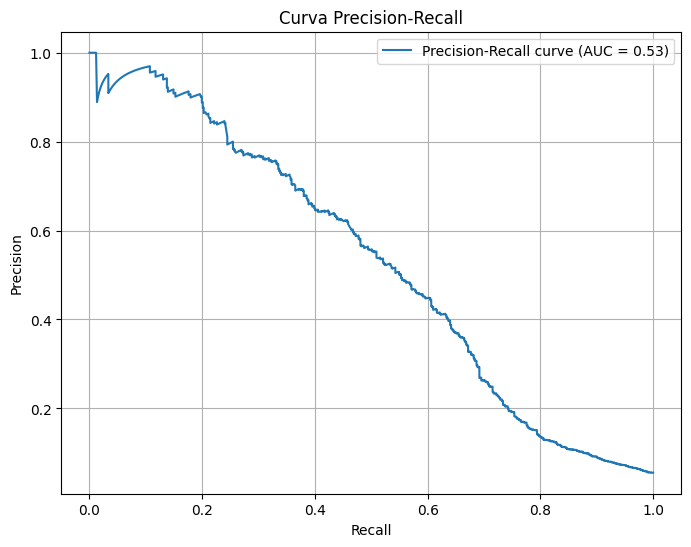

In [4]:
#local de salvamento do modelo
pasta_modelo = '../models/'
logistic_regression_model_pkl = pasta_modelo + 'logistic_regression_model.pkl'
tfidf_vectorizer_applicant_pkl = pasta_modelo + 'tfidf_vectorizer_applicant.pkl'
tfidf_vectorizer_job_pkl = pasta_modelo + 'tfidf_vectorizer_job.pkl'
categorical_cols_pkl = pasta_modelo + 'categorical_cols.pkl'
encoded_feature_names_pkl = pasta_modelo + 'encoded_feature_names.pkl'
precision_recall_curve_png = pasta_modelo + 'precision_recall_curve.png'

# Load the processed data
# Carrega o DataFrame processado que foi salvo na etapa anterior.
# Este DataFrame já deve ter as colunas indesejadas removidas conforme sua última solicitação.
try:
    merged_df = pd.read_csv(merged_data_processed)
    print(f"DataFrame processado {merged_data_processed} carregado com sucesso.")
except FileNotFoundError:
    print(f"Erro: {merged_data_processed} não encontrado. Por favor, execute as etapas anteriores para criá-lo.")
    exit()

# --- Text Vectorization (TF-IDF) ---
# Vetorização de features de texto usando TF-IDF.
print("\nIniciando vetorização TF-IDF para features de texto com stop words em português...")

# Lista de stop words comuns em português.
portuguese_stop_words = [
    'a', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das',
    'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre',
    'era', 'eram', 'essa', 'essas', 'esse', 'esses', 'esta', 'estas', 'este', 'estes', 'estou', 'está', 'estão', 'eu',
    'foi', 'fomos', 'for', 'fora', 'foram', 'fosse', 'fossem', 'fui', 'há', 'isso', 'isto', 'já', 'lhe', 'lhes', 'mais',
    'mas', 'me', 'mesmo', 'meu', 'meus', 'minha', 'minhas', 'muito', 'na', 'nas', 'nem', 'no', 'nos', 'nossa', 'nossas',
    'nosso', 'nossos', 'num', 'numa', 'o', 'os', 'ou', 'para', 'pela', 'pelas', 'pelo', 'pelos', 'por', 'porque', 'qual',
    'quando', 'que', 'quem', 'se', 'sem', 'ser', 'será', 'serão', 'serei', 'seremos', 'seria', 'seriam', 'seu', 'seus',
    'só', 'somos', 'sou', 'sua', 'suas', 'também', 'te', 'tem', 'tém', 'temos', 'tenho', 'terá', 'terão', 'terei',
    'teremos', 'teria', 'teriam', 'teu', 'teus', 'tive', 'tivemos', 'tiver', 'tivera', 'tiveram', 'tivesse', 'tivessem',
    'tivemos', 'tiveram', 'todas', 'todo', 'todos', 'tu', 'tua', 'tuas', 'um', 'uma', 'você', 'vocês', 'vos'
]


# Inicializa o TfidfVectorizer para as features de texto do candidato e da vaga.
# max_features limita o número de palavras (features) para evitar alta dimensionalidade.
tfidf_vectorizer_applicant = TfidfVectorizer(stop_words=portuguese_stop_words, max_features=5000, lowercase=True)
tfidf_vectorizer_job = TfidfVectorizer(stop_words=portuguese_stop_words, max_features=5000, lowercase=True)


# Aplica o TF-IDF nas features de texto dos candidatos.
applicant_tfidf = tfidf_vectorizer_applicant.fit_transform(merged_df['applicant_text_features'])
print(f"Shape do TF-IDF para candidatos: {applicant_tfidf.shape}")

# Aplica o TF-IDF nas features de texto das vagas.
job_tfidf = tfidf_vectorizer_job.fit_transform(merged_df['job_text_features'])
print(f"Shape do TF-IDF para vagas: {job_tfidf.shape}")

# --- Categorical Feature Encoding (One-Hot Encoding) ---
# Codificação de features categóricas usando One-Hot Encoding.
print("\nIniciando One-Hot Encoding para features categóricas...")

# Lista de colunas categóricas a serem codificadas.
# Esta lista deve conter apenas as colunas categóricas que você deseja manter
# e que não foram excluídas na etapa de pré-processamento.
categorical_cols = [
    'modalidade_vaga_prospect',
    'tipo_contratacao',
    'nivel profissional', # Atenção ao espaço no nome da coluna
    'nivel_academico',
    'nivel_ingles',
    'nivel_espanhol',
    'sexo',
    'estado_civil',
    'pcd',
    'pais',
    'estado',
    'cidade',
    'regiao',
    'faixa_etaria',
    'horario_trabalho',
    'vaga_especifica_para_pcd',
    'origem_vaga'
]

# Filtra as colunas que realmente existem no DataFrame mesclado.
existing_categorical_cols = [col for col in categorical_cols if col in merged_df.columns]
missing_categorical_cols = [col for col in categorical_cols if col not in merged_df.columns]

if missing_categorical_cols:
    print(f"Aviso: As seguintes colunas categóricas não foram encontradas no DataFrame mesclado e serão ignoradas: {missing_categorical_cols}")

# Converte todos os valores das colunas categóricas existentes para string e preenche NaNs com string vazia.
for col in existing_categorical_cols:
    merged_df[col] = merged_df[col].astype(str).fillna('')

# Realiza o One-Hot Encoding. `dummy_na=False` evita a criação de uma coluna para valores NaN.
encoded_features = pd.get_dummies(merged_df[existing_categorical_cols], dummy_na=False)
print(f"Shape das features categóricas codificadas: {encoded_features.shape}")

# --- Combining all features ---
# Combina todas as features (TF-IDF e categóricas codificadas) em uma única matriz.
# Converte o DataFrame de features codificadas para uma matriz esparsa.
encoded_features_sparse = csr_matrix(encoded_features)

# Empilha horizontalmente todas as features.
X = hstack([applicant_tfidf, job_tfidf, encoded_features_sparse])
y = merged_df['contratado'] # Variável alvo (0 para não contratado, 1 para contratado)

print(f"\nShape final da matriz de features (X): {X.shape}")
print(f"Shape final do vetor de rótulos (y): {y.shape}")

# --- Data Splitting ---
# Divide os dados em conjuntos de treinamento e teste.
# `test_size=0.2` significa 20% dos dados para teste.
# `random_state=42` garante reprodutibilidade.
# `stratify=y` mantém a proporção das classes (contratado/não contratado) em ambos os conjuntos.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nShape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")

# --- Model Training (Logistic Regression as a baseline) ---
# Treinamento do modelo de Regressão Logística.
print("\nIniciando treinamento do modelo Logistic Regression...")

# `solver='saga'` é adequado para grandes datasets e matrizes esparsas.
# `max_iter` aumentado para garantir convergência.
# `n_jobs=-1` utiliza todos os núcleos da CPU disponíveis.
log_reg_model = LogisticRegression(solver='saga', max_iter=1000, random_state=42, n_jobs=-1)
log_reg_model.fit(X_train, y_train)

print("\nTreinamento do modelo concluído.")

# --- Model Evaluation ---
# Avaliação do desempenho do modelo.
print("\nIniciando avaliação do modelo...")

# Faz previsões no conjunto de teste.
y_pred = log_reg_model.predict(X_test)
# Obtém as probabilidades da classe positiva (contratado).
y_proba = log_reg_model.predict_proba(X_test)[:, 1]

print("\n--- Relatório de Classificação ---")
# Exibe o relatório de classificação com Precision, Recall e F1-Score.
print(classification_report(y_test, y_pred))

# Calcula a área sob a curva ROC (AUC-ROC).
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nAUC-ROC: {roc_auc:.4f}")

# Plotting Precision-Recall Curve
# Calcula a curva Precision-Recall.
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision) # Calcula a área sob a curva Precision-Recall.

# Gera e salva o gráfico da curva Precision-Recall.
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)
#plt.savefig(precision_recall_curve_png) # Salva a imagem do gráfico.
#print(f"Curva Precision-Recall salva como {precision_recall_curve_png}.")

# --- Save the Trained Model and Preprocessing Objects ---
# Salva o modelo treinado e os objetos de pré-processamento (vetorizadores TF-IDF).
# Isso é crucial para usar o modelo em produção sem retreiná-lo.
print("\nSalvando o modelo treinado e os objetos de pré-processamento...")
try:
    joblib.dump(log_reg_model, logistic_regression_model_pkl)
    joblib.dump(tfidf_vectorizer_applicant, tfidf_vectorizer_applicant_pkl)
    joblib.dump(tfidf_vectorizer_job, tfidf_vectorizer_job_pkl)
    # Para as features categóricas, como usamos pd.get_dummies diretamente,
    # não há um objeto OneHotEncoder separado para salvar.
    # No entanto, é importante que as colunas categóricas e seus valores únicos
    # sejam consistentes entre o treinamento e a inferência.
    # Você pode salvar a lista de colunas categóricas e os valores únicos se necessário para validação.
    joblib.dump(existing_categorical_cols, categorical_cols_pkl) # Salva as colunas categóricas usadas.
    joblib.dump(encoded_features.columns.tolist(), encoded_feature_names_pkl) # Salva os nomes das colunas após o OHE

    print("Modelo, vetorizadores TF-IDF e informações de colunas categóricas salvos com sucesso.")
except Exception as e:
    print(f"Erro ao salvar os objetos: {e}")

print("\n--- Exemplo de Recomendação ---")
# Demonstração conceitual de como as recomendações seriam feitas.
# Como 'codigo_vaga' foi removida, o exemplo de seleção de vaga será conceitual.

print("\nO modelo de classificação foi treinado. Para fazer recomendações, você precisaria:")
print("1. Carregar o modelo e os objetos de pré-processamento salvos.")
print("2. Selecionar uma vaga (por exemplo, uma nova vaga ou uma vaga existente para a qual você quer encontrar candidatos).")
print("3. Para cada candidato disponível (que ainda não foi contratado para essa vaga):")
print("   a. Criar uma entrada de dados combinando as características do candidato e as características da vaga (similar à forma como o 'X' foi construído).")
print("   b. Pré-processar esta entrada usando os *mesmos* vetorizadores TF-IDF e a lógica de codificação categórica usados no treinamento.")
print("   c. Usar o modelo `log_reg_model.predict_proba()` para obter a probabilidade de contratação.")
print("4. Classificar os candidatos com base nessas probabilidades para gerar uma lista de recomendação.")

print("\nAs principais métricas do modelo são: Precision, Recall, F1-Score e AUC-ROC, que estão no relatório de classificação acima e na curva Precision-Recall. Estas métricas ajudam a entender a capacidade do modelo em identificar candidatos que serão contratados.")
